# **The Problem & Business Importance**





# **Data Identification & Analysis**

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from KNN_D import KNN_D

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split , KFold
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC
from xgboost import XGBClassifier

In [63]:
df = pd.read_csv('i4talent_dataset.csv')
df['datum'] = pd.to_datetime(df['datum'])
df['geboortedatum'] = pd.to_datetime(df['geboortedatum'])
df['indiensttreding_datum'] = pd.to_datetime(df['indiensttreding_datum'])


In [64]:
df.head()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,uitdiensttreding_datum,leeftijd,lengte_dienst,stad,afdeling,klant_id,geslacht_id,geslacht,uitdiensttreding_reden,uitdiensttreding_type,STATUS_JAAR,STATUS,BUSINESS_UNIT
0,6962,2018-12-31 05:06:00,1989-06-26 05:06:00,2013-05-23 05:06:00,1905-01-01 05:06:00,29.0,5.0,Amstelveen,BI,30,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
1,6212,2016-12-30 05:06:00,1983-08-25 05:06:00,2010-04-24 05:06:00,1905-01-01 05:06:00,33.0,6.0,Utrecht,Accountant,21,M,Man,Niet van toepassing,Niet van toepassing,2016,Actief,Detachering
2,5325,2018-12-31 05:06:00,1976-04-24 05:06:00,2006-06-09 05:06:00,1905-01-01 05:06:00,42.0,12.0,Amsterdam,BI,42,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
3,8193,2018-12-31 05:06:00,1998-10-26 05:06:00,2018-04-28 05:06:00,1905-01-01 05:06:00,20.0,NaN,Utrecht,BI,21,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
4,5926,2013-12-31 05:06:00,1981-03-19 05:06:00,2009-01-09 05:06:00,1905-01-01 05:06:00,32.0,4.0,Den Haag,Accountant,18,M,Man,Niet van toepassing,Niet van toepassing,2013,Actief,Detachering


In [65]:
df.describe()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,leeftijd,lengte_dienst,klant_id,STATUS_JAAR
count,49753.000000,49753,49753,49753,44653.000000,44802.000000,49753.000000,49753.000000
mean,4859.473600,2016-08-06 00:21:52.006914304,1974-01-10 05:10:34.379434400,2005-09-04 11:13:13.710530176,42.046223,10.442592,27.296525,2015.612566
min,1318.000000,2011-01-01 05:06:00,1946-01-15 05:06:00,1994-08-28 05:06:00,19.000000,0.000000,1.000000,2011.000000
25%,3360.000000,2013-12-31 05:06:00,1963-05-28 05:06:00,2000-06-01 05:06:00,31.000000,5.000000,16.000000,2013.000000
50%,5031.000000,2016-12-30 05:06:00,1973-12-04 05:06:00,2005-03-31 05:06:00,42.000000,10.000000,28.000000,2016.000000
75%,6335.000000,2018-12-31 05:06:00,1984-07-17 05:06:00,2010-10-13 05:06:00,53.000000,15.000000,42.000000,2018.000000
max,8336.000000,2020-12-30 05:06:00,1999-12-31 05:06:00,2018-12-11 05:06:00,65.000000,26.000000,46.000000,2020.000000
std,1827.113618,NaN,NaN,NaN,12.424199,6.326893,13.512861,2.845621


In [66]:
print(df.isna().sum())

WerknemerID                  0
datum                        0
geboortedatum                0
indiensttreding_datum        0
uitdiensttreding_datum       0
leeftijd                  5100
lengte_dienst             4951
stad                      5543
afdeling                  5065
klant_id                     0
geslacht_id                  0
geslacht                     0
uitdiensttreding_reden       0
uitdiensttreding_type        0
STATUS_JAAR                  0
STATUS                       0
BUSINESS_UNIT                0
dtype: int64


In [67]:
df_test = df.copy()
df['leeftijd'] = df['leeftijd'].fillna((df['datum'] - df['geboortedatum']).dt.days // 365)
df['lengte_dienst'] = df['lengte_dienst'].fillna((df['datum'] - df['indiensttreding_datum']).dt.days // 365)


In [68]:
duplicates = df[df.duplicated(subset='WerknemerID', keep=False)].dropna()

for werknemer_id, group in duplicates.groupby('WerknemerID'):
    if group['stad'].nunique() != 1 or group['afdeling'].nunique() != 1 :
        print(f"Different 'stad' values found for WerknemerID {werknemer_id}: {group['stad'].unique()}")


In [69]:
df_test['leeftijd']
df_test['test_leeftijd'] = (df_test['datum'] - df_test['geboortedatum']).dt.days // 365

df_test_filter = df_test[df_test['leeftijd'] != df_test['test_leeftijd']]

# Filter rows where 'leeftijd' does not match 'test_leeftijd' and both are not NaN
df_test_filter = df_test[
    (df_test['leeftijd'] != df_test['test_leeftijd']) & 
    (df_test['leeftijd'].notna()) & 
    (df_test['test_leeftijd'].notna())
]

In [70]:
df_sort = df.sort_values(by=['WerknemerID', 'datum'])
# filling in the missing values based on values that where put first.
df_sort['stad'] = df_sort.groupby('WerknemerID')['stad'].ffill()
most_common_value = df_sort['stad'].mode()[0]  
df_sort['stad'] = df_sort['stad'].fillna(most_common_value)

df_sort['afdeling'] = df_sort.groupby('WerknemerID')['afdeling'].ffill()
most_common_value_2 = df_sort['afdeling'].mode()[0]  
df_sort['afdeling'] = df_sort['afdeling'].fillna(most_common_value_2)

In [71]:
df_sort = df_sort.sort_values(by='datum', ascending=False)
df_sort = df_sort.drop_duplicates(subset='WerknemerID', keep='first')

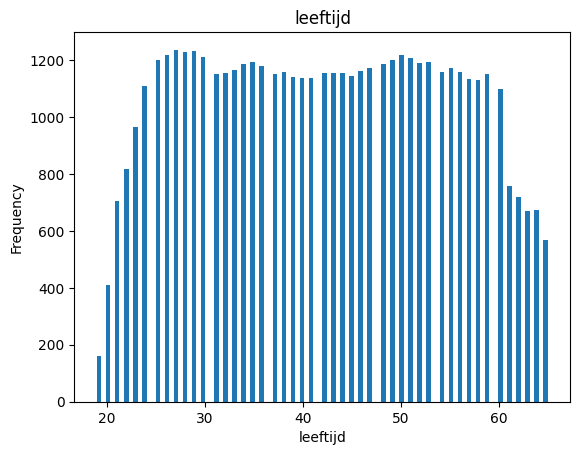

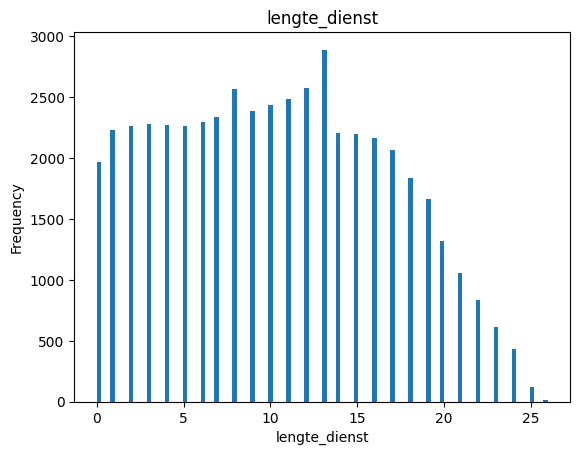

In [72]:
columns_numerical_with_nas = ['leeftijd', 'lengte_dienst']
for col in columns_numerical_with_nas:
    plt.hist(df[col], bins=100)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [73]:
columns_to_delete = ['geboortedatum', 'WerknemerID', 'uitdiensttreding_datum', 'indiensttreding_datum', 'geslacht', 'uitdiensttreding_type', 'datum', 'STATUS_JAAR', 'uitdiensttreding_reden']
df_new = df_sort.drop(columns=columns_to_delete)


In [74]:
df_with_dummies = pd.get_dummies(df_new, columns=['stad', 'afdeling', 'geslacht_id', 'STATUS', 'BUSINESS_UNIT'], drop_first=True , dtype = int)

In [75]:
#Used later for model evaluation
model_scores = {}

#You can download the pretrained models here : https://github.com/dvanaanhout/GROUP5
#Saves time running the file.

In [76]:
X = df_with_dummies.drop(columns=['STATUS_Beëindigd'])
y = df_with_dummies['STATUS_Beëindigd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:

saved_model_name = 'model_lr.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr = loaded_model
else:
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train)
    joblib.dump(model_lr, saved_model_name)

y_pred = model_lr.predict(X_test)

params = model_lr.get_params()
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)


model_scores['Logistic Regression'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}


conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))



Train Score: 0.9600159140640541
Test Score: 0.9626093874303898
Confusion Matrix:
[[956   2]
 [ 45 254]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       958
           1       0.99      0.85      0.92       299

    accuracy                           0.96      1257
   macro avg       0.97      0.92      0.95      1257
weighted avg       0.96      0.96      0.96      1257



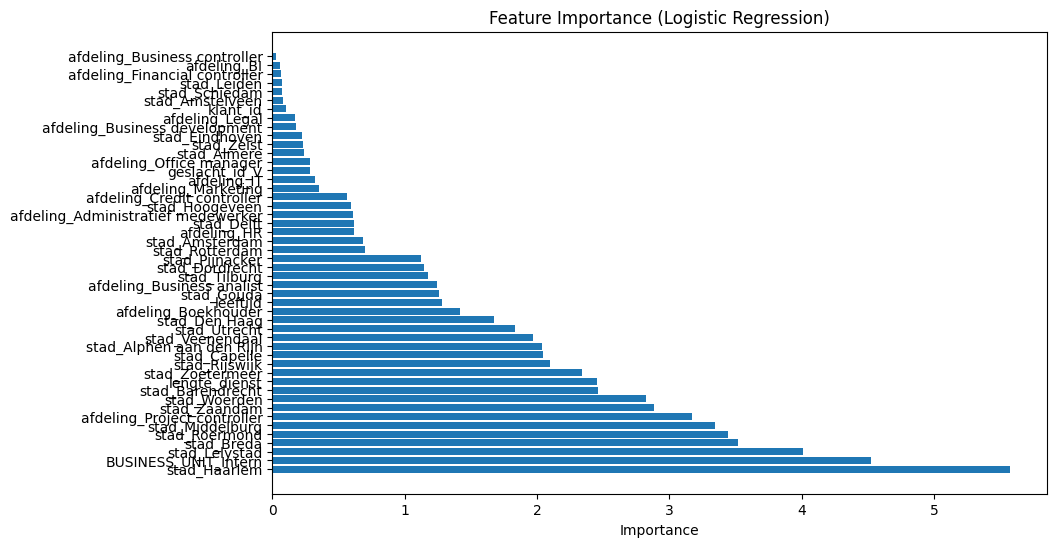

In [78]:
coefficients = model_lr.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

In [79]:
saved_model_name = 'model_lr_TUNED.joblib'

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr_TUNED = loaded_model
else:
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_lr_TUNED = grid_search.best_estimator_
    joblib.dump(model_lr_TUNED, saved_model_name)

y_pred = model_lr_TUNED.predict(X_test)

train_score = model_lr_TUNED.score(X_train, y_train)
test_score = model_lr_TUNED.score(X_test, y_test)

params = model_lr_TUNED.get_params()

model_scores['Logistic Regression TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Train Score: 0.959419136662025
Test Score: 0.9657915672235481
Confusion Matrix:
[[956   2]
 [ 41 258]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       958
           1       0.99      0.86      0.92       299

    accuracy                           0.97      1257
   macro avg       0.98      0.93      0.95      1257
weighted avg       0.97      0.97      0.96      1257



In [80]:
saved_model_name = 'model_HGBC.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_hgb = loaded_model

else:
    model_hgb = HistGradientBoostingClassifier()
    model_hgb.fit(X_train, y_train)
    joblib.dump(model_hgb, saved_model_name)


y_pred = model_hgb.predict(X_test)

train_score = model_hgb.score(X_train, y_train)
test_score = model_hgb.score(X_test, y_test)

params = model_hgb.get_params()

model_scores['Hist Gradient Boosting'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

Train Score: 0.9980107419932365
Test Score: 0.9840891010342084
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       958
           1       0.98      0.95      0.97       299

    accuracy                           0.98      1257
   macro avg       0.98      0.97      0.98      1257
weighted avg       0.98      0.98      0.98      1257



In [81]:
saved_model_name = 'model_HGBC_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_HGBC_TUNED = loaded_model
else:
    model_HGBC_TUNED = HistGradientBoostingClassifier()
    param_grid = {
        'max_iter': [100, 200,300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9, 21, 25],
        'min_samples_leaf': [1, 5, 10, 15, 20]
    }

    grid_search = GridSearchCV(estimator=model_HGBC_TUNED, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model_HGBC_TUNED = grid_search.best_estimator_
    joblib.dump(best_model_HGBC_TUNED, saved_model_name)
    model_HGBC_TUNED = best_model_HGBC_TUNED

y_pred = model_HGBC_TUNED.predict(X_test)

train_score = model_HGBC_TUNED.score(X_train, y_train)
test_score = model_HGBC_TUNED.score(X_test, y_test)

params = model_HGBC_TUNED.get_params()

model_scores['Hist Gradient Boosting TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9980107419932365
Test Score: 0.9888623707239459
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       958
           1       0.98      0.97      0.98       299

    accuracy                           0.99      1257
   macro avg       0.99      0.98      0.98      1257
weighted avg       0.99      0.99      0.99      1257



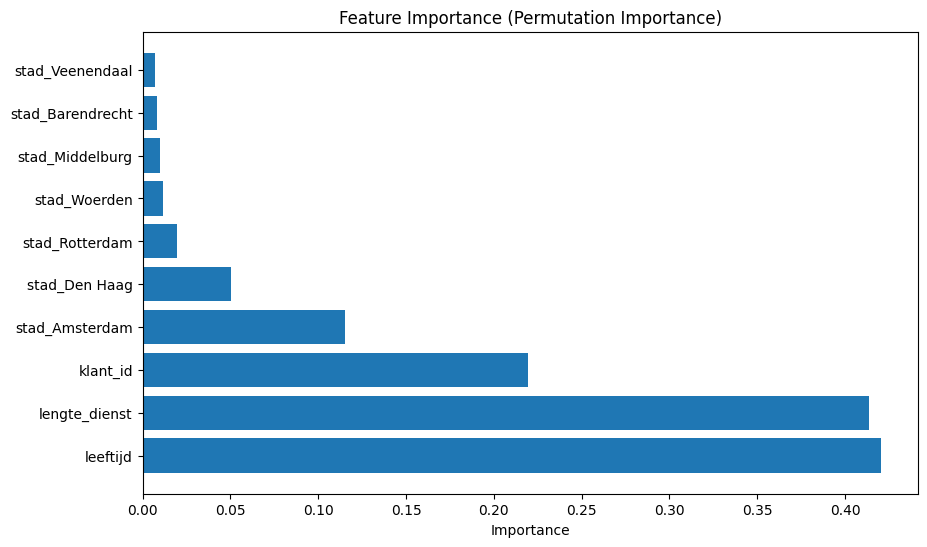

In [104]:
result = permutation_importance(model_HGBC_TUNED, X_train, y_train, n_repeats=10, random_state=42, scoring='accuracy')

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

feature_importance = feature_importance[feature_importance['Importance'] > 0.005]
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance']) 
plt.xlabel('Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.show()


In [83]:
saved_model_name = 'model_KNN.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn = loaded_model
else:
    model_knn = KNeighborsClassifier()
    model_knn.fit(X_train, y_train)
    joblib.dump(model_knn, saved_model_name)

y_pred = model_knn.predict(X_test)

train_score = model_knn.score(X_train, y_train)
test_score = model_knn.score(X_test, y_test)

params = model_knn.get_params()

model_scores['KNN'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

[[952   6]
 [ 69 230]]
Train Score: 0.9566341754525562
Test Score: 0.9403341288782816
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       958
           1       0.97      0.77      0.86       299

    accuracy                           0.94      1257
   macro avg       0.95      0.88      0.91      1257
weighted avg       0.94      0.94      0.94      1257



In [84]:

saved_model_name = 'model_KNN_TUNED.joblib'

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn_TUNED = loaded_model
else:
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_knn_TUNED = grid_search.best_estimator_
    joblib.dump(model_knn_TUNED, saved_model_name)

y_pred = model_knn_TUNED.predict(X_test)

train_score = model_knn_TUNED.score(X_train, y_train)
test_score = model_knn_TUNED.score(X_test, y_test)

params = model_knn_TUNED.get_params()

model_scores['KNN TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.973741794310722
Test Score: 0.9570405727923628
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       958
           1       0.97      0.84      0.90       299

    accuracy                           0.96      1257
   macro avg       0.96      0.92      0.94      1257
weighted avg       0.96      0.96      0.96      1257



In [85]:
model_KNN_D = KNN_D()
model_KNN_D.fit(X_train, y_train)


y_train_pred = model_KNN_D.predict(X_train)
y_test_pred = model_KNN_D.predict(X_test)


train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

model_scores['KNN_D'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : 'dcalc = Euclidean , NN = 5'
}
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

[[951   7]
 [ 47 252]]
Train Score: 0.9568331012532325
Test Score: 0.9379474940334129
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       958
           1       0.97      0.84      0.90       299

    accuracy                           0.96      1257
   macro avg       0.96      0.92      0.94      1257
weighted avg       0.96      0.96      0.96      1257



In [86]:
saved_model_name = 'model_XGBoost.joblib'


if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost = loaded_model
else:
    model_xgboost = XGBClassifier()
    model_xgboost.fit(X_train, y_train)
    joblib.dump(model_xgboost, saved_model_name)

y_pred = model_xgboost.predict(X_test)

train_score = model_xgboost.score(X_train, y_train)
test_score = model_xgboost.score(X_test, y_test)

params = model_xgboost.get_params()

model_scores['XGBoost Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

[[954   4]
 [ 12 287]]
Train Score: 0.9978118161925602
Test Score: 0.9872712808273667
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       958
           1       0.99      0.96      0.97       299

    accuracy                           0.99      1257
   macro avg       0.99      0.98      0.98      1257
weighted avg       0.99      0.99      0.99      1257



In [87]:
saved_model_name = 'model_XGBoost_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_xgboost_TUNED = grid_search.best_estimator_
    joblib.dump(model_xgboost_TUNED, saved_model_name)

y_pred = model_xgboost_TUNED.predict(X_test)

train_score = model_xgboost_TUNED.score(X_train, y_train)
test_score = model_xgboost_TUNED.score(X_test, y_test)

params = model_xgboost_TUNED.get_params()

model_scores['XGBoost Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9978118161925602
Test Score: 0.9872712808273667
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       958
           1       0.99      0.96      0.97       299

    accuracy                           0.99      1257
   macro avg       0.99      0.98      0.98      1257
weighted avg       0.99      0.99      0.99      1257



In [88]:
saved_model_name = 'model_ridge.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_ridge = loaded_model
else:
    model_ridge = RidgeClassifier()
    model_ridge.fit(X_train, y_train)
    joblib.dump(model_ridge, saved_model_name)


y_pred = model_ridge.predict(X_test)

train_score = model_ridge.score(X_train, y_train)
test_score = model_ridge.score(X_test, y_test)

params = model_ridge.get_params()

model_scores['Ridge Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9049134672767057
Test Score: 0.9132856006364359
Confusion Matrix:
[[957   1]
 [108 191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       958
           1       0.99      0.64      0.78       299

    accuracy                           0.91      1257
   macro avg       0.95      0.82      0.86      1257
weighted avg       0.92      0.91      0.91      1257



In [89]:
saved_model_name = 'model_ridge_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_ridge_TUNED = loaded_model
else:
    model_ridge_TUNED = RidgeClassifier()
    model_ridge_TUNED.fit(X_train, y_train)
    joblib.dump(model_ridge_TUNED, saved_model_name)

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
}

y_pred = model_ridge_TUNED.predict(X_test)

train_score = model_ridge_TUNED.score(X_train, y_train)
test_score = model_ridge_TUNED.score(X_test, y_test)

params = model_ridge_TUNED.get_params()

model_scores['Ridge Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9049134672767057
Test Score: 0.9132856006364359
Confusion Matrix:
[[957   1]
 [108 191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       958
           1       0.99      0.64      0.78       299

    accuracy                           0.91      1257
   macro avg       0.95      0.82      0.86      1257
weighted avg       0.92      0.91      0.91      1257



In [90]:
saved_model_name = 'model_lasso_classifier.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lasso_classifier = loaded_model
else:
    model_lasso_classifier = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
    model_lasso_classifier.fit(X_train, y_train)
    joblib.dump(model_lasso_classifier, saved_model_name)


y_pred = model_lasso_classifier.predict(X_test)

train_score = model_lasso_classifier.score(X_train, y_train)
test_score = model_lasso_classifier.score(X_test, y_test)

params = model_lasso_classifier.get_params()

model_scores['Lasso Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Train Score: 0.9478814402227969
Test Score: 0.9482895783611774
Confusion Matrix:
[[956   2]
 [ 63 236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       958
           1       0.99      0.79      0.88       299

    accuracy                           0.95      1257
   macro avg       0.96      0.89      0.92      1257
weighted avg       0.95      0.95      0.95      1257



In [91]:
saved_model_name = 'model_lasso_classifier_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lasso_classifier_TUNED = loaded_model
else:
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 2000]
    }
    base_model = LogisticRegression(penalty='l1', solver='saga')
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_lasso_classifier_TUNED = grid_search.best_estimator_
    joblib.dump(model_lasso_classifier_TUNED, saved_model_name)


y_pred = model_lasso_classifier_TUNED.predict(X_test)

train_score = model_lasso_classifier_TUNED.score(X_train, y_train)
test_score = model_lasso_classifier_TUNED.score(X_test, y_test)

params = model_lasso_classifier_TUNED.get_params()

model_scores['Lasso Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9564352496518799
Test Score: 0.9530628480509149
Confusion Matrix:
[[956   2]
 [ 57 242]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       958
           1       0.99      0.81      0.89       299

    accuracy                           0.95      1257
   macro avg       0.97      0.90      0.93      1257
weighted avg       0.96      0.95      0.95      1257



In [92]:
saved_model_name = 'model_DTC.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_DTC = loaded_model
else:
    model_DTC = DecisionTreeClassifier(random_state=42)
    model_DTC.fit(X_train, y_train)
    joblib.dump(model_DTC, saved_model_name)

y_pred = model_DTC.predict(X_test)

train_score = model_DTC.score(X_train, y_train)
test_score = model_DTC.score(X_test, y_test)

params = model_DTC.get_params()

model_scores['Decision Tree Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

Train Score: 0.9980107419932365
Test Score: 0.9824980111376292
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       958
           1       0.98      0.95      0.96       299

    accuracy                           0.98      1257
   macro avg       0.98      0.97      0.98      1257
weighted avg       0.98      0.98      0.98      1257

Confusion Matrix:
[[951   7]
 [ 15 284]]


In [93]:
saved_model_name = 'model_DTC_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_DT_TUNED = loaded_model
else:
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model_DT_TUNED = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model_DT_TUNED, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    model_DT_TUNED = grid_search.best_estimator_
    joblib.dump(model_DT_TUNED, saved_model_name)

y_pred = model_DT_TUNED.predict(X_test)

train_score = model_DT_TUNED.score(X_train, y_train)
test_score = model_DT_TUNED.score(X_test, y_test)

params = model_DT_TUNED.get_params()

model_scores['Decision Tree Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

Train Score: 0.9980107419932365
Test Score: 0.9824980111376292
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       958
           1       0.98      0.95      0.96       299

    accuracy                           0.98      1257
   macro avg       0.98      0.97      0.98      1257
weighted avg       0.98      0.98      0.98      1257

Confusion Matrix:
[[951   7]
 [ 15 284]]


In [94]:
saved_model_name = 'model_RandomForestClassifier.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF = loaded_model
else:
    model_RF = RandomForestClassifier(random_state=42)
    model_RF.fit(X_train, y_train)
    joblib.dump(model_RF, saved_model_name)

y_pred = model_RF.predict(X_test)

train_score = model_RF.score(X_train, y_train)
test_score = model_RF.score(X_test, y_test)

params = model_RF.get_params()

model_scores['Random Forest Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.9980107419932365
Test Score: 0.9761336515513126
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       958
           1       0.98      0.92      0.95       299

    accuracy                           0.98      1257
   macro avg       0.98      0.96      0.97      1257
weighted avg       0.98      0.98      0.98      1257

Confusion Matrix:
[[952   6]
 [ 24 275]]


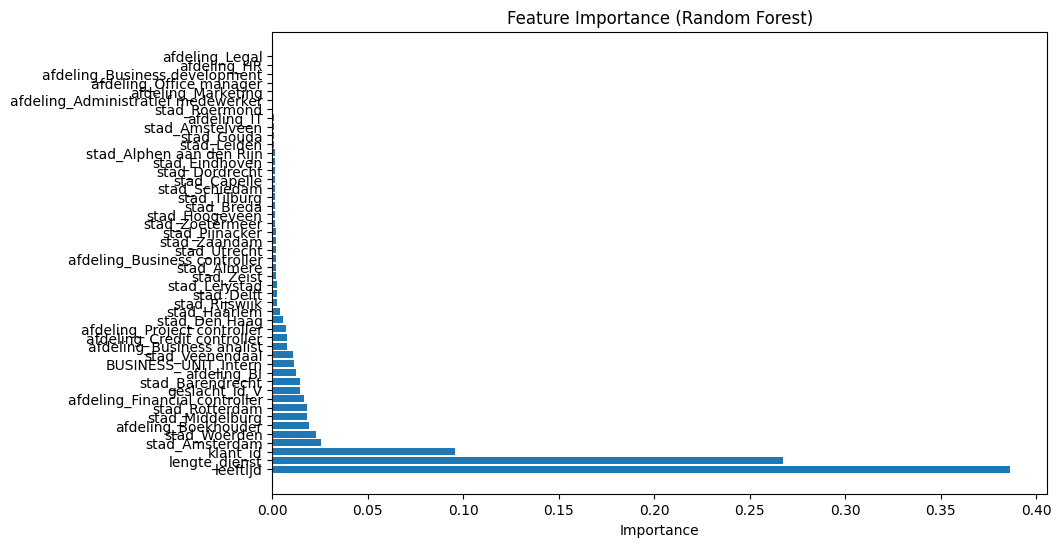

In [95]:
importances = model_RF.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [96]:
saved_model_name = 'model_RandomForest_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_RF_TUNED = grid_search.best_estimator_
    joblib.dump(model_RF_TUNED, saved_model_name)

y_pred = model_RF_TUNED.predict(X_test)

train_score = model_RF_TUNED.score(X_train, y_train)
test_score = model_RF_TUNED.score(X_test, y_test)

params = model_RF_TUNED.get_params()

model_scores['Random Forest Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.9948279291824149
Test Score: 0.9753381066030231
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       958
           1       0.98      0.92      0.95       299

    accuracy                           0.98      1257
   macro avg       0.98      0.96      0.97      1257
weighted avg       0.98      0.98      0.98      1257

Confusion Matrix:
[[952   6]
 [ 25 274]]


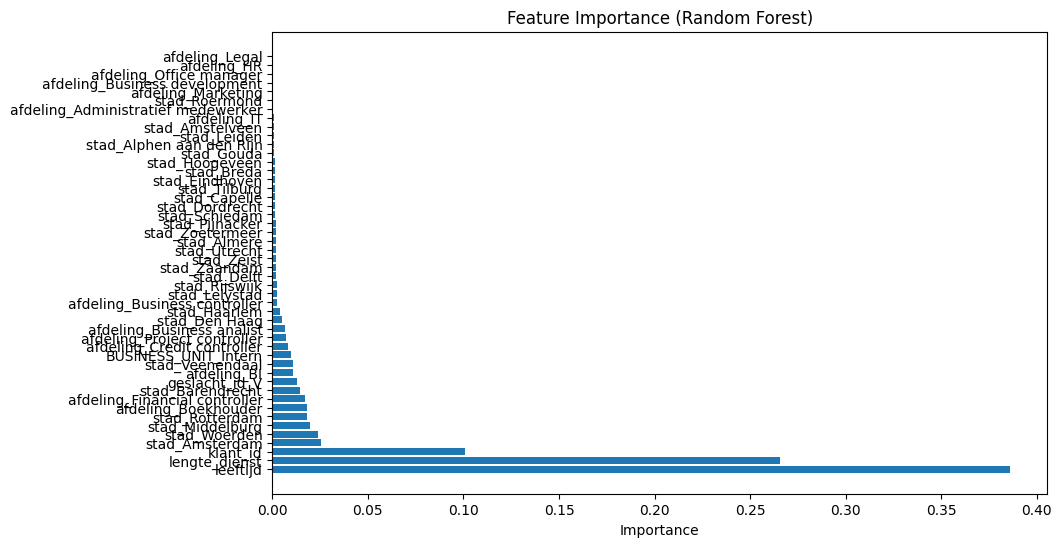

In [97]:
importances = model_RF_TUNED.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [98]:
saved_model_name = 'model_svm_classifier_DEFAULT.joblib'

if os.path.exists(saved_model_name):
    model_svm_classifier = joblib.load(saved_model_name)
else:
    model_svm_classifier = SVC()  
    model_svm_classifier.fit(X_train, y_train)
    joblib.dump(model_svm_classifier, saved_model_name)

y_pred = model_svm_classifier.predict(X_test)

train_score = model_svm_classifier.score(X_train, y_train)
test_score = model_svm_classifier.score(X_test, y_test)

params = model_svm_classifier.get_params()

model_scores['SVM Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used parameters' : params
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Train Score: 0.8750745971752536
Test Score: 0.8743038981702467
Confusion Matrix:
[[957   1]
 [157 142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       958
           1       0.99      0.47      0.64       299

    accuracy                           0.87      1257
   macro avg       0.93      0.74      0.78      1257
weighted avg       0.89      0.87      0.86      1257



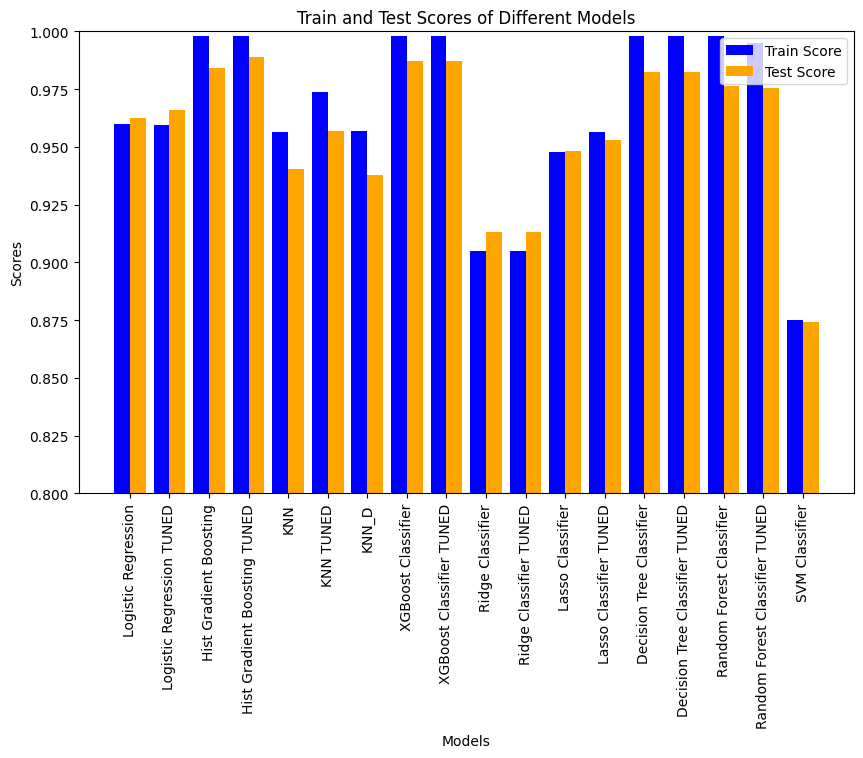

In [99]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0.8, 1)
plt.legend()
plt.show()


In [100]:
best_model = max(model_scores, key=lambda x: model_scores[x]['Test Score'])
print(best_model)
print(model_scores[best_model]['Train Score']) 
print(model_scores[best_model]['Test Score'])
print(model_scores[best_model]['Used parameters']) 

worst_model = min(model_scores, key=lambda x: model_scores[x]['Test Score'])
print(worst_model)
print(model_scores[worst_model]['Train Score']) 
print(model_scores[worst_model]['Test Score'])
print(model_scores[worst_model]['Used parameters']) 

Hist Gradient Boosting TUNED
0.9980107419932365
0.9888623707239459
{'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 3, 'max_features': 1.0, 'max_iter': 300, 'max_leaf_nodes': 31, 'min_samples_leaf': 5, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
SVM Classifier
0.8750745971752536
0.8743038981702467
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Find at employees at risk of leaving.

In [101]:
X = df_with_dummies.drop('STATUS_Beëindigd', axis=1)
y = df_with_dummies['STATUS_Beëindigd']

model = RandomForestClassifier()
kf = KFold(n_splits=10)

predicted_vals = []

for i, j in kf.split(X):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predicted_vals.extend(predictions)

df_n_dummies = pd.get_dummies(df_sort , columns=['STATUS'] , drop_first=True)
df_sort['pred_STATUS_Beëindigd'] = predicted_vals

at_risk_employees = df_n_dummies[(df_n_dummies['pred_STATUS_Beëindigd'] == True) & (df_n_dummies['STATUS_Beëindigd'] == False)]
at_risk_employees


KeyError: 'pred_STATUS_Beëindigd'